In [2]:
import os
import pandas as pd
import numpy as np
import json
import re
import itertools
from qiniu import Auth, put_file, etag, BucketManager
import qiniu.config
import hashlib
access_key = 'XzkCvQGvOaJjSRplhsT_8w1jo2KTmh8JscS_DPrm'
secret_key = 'BOQtOJeSCbNRV9gtbKS3l0FLCy3M9DI_oKUujyHn'
bucket_name = 'sanchaliushui'
qiniu_auth = Auth(access_key, secret_key)
bucket = BucketManager(qiniu_auth)


In [3]:
def json_process(json_info):
    json_info = re.sub(r'[\r\n]+', '', json_info)
    dict_info = json.loads(json_info)
    dict_info_copy = {}
    for key, val in dict_info.items():
        dict_info_copy[key.lower()] = val
    return dict_info_copy

def original_title_process(original_title):
    '''
    商品原始名称中有时带特殊符号，在保存文件夹时，文件夹名称会讲特殊符号改成'_'
    '''
    return re.sub(r"[~]", '_', original_title)

def convert_unit_metric_english(string_value):
    '''
    某些属性名包含公制单位，例如"Gold 40cm"、”51cm-60cm“、”51-60cm“,”0.01kg“
    '''
    conversion_rates = {
                       'cm': ('inch', 0.3937),
                       'kg': ('lb', 2.2046),
                       'g': ('lb', 0.0022046),
                       }
    if re.search(r'(\d+(\.\d+)?)(inch(es)?|lb)', string_value.lower()):
        return string_value

    #解决型如51.0cm-60cm、60cm
    def convert_single(match_obj):
        metric_num = float(match_obj.group(1))
        metric_unit = match_obj.group(3).lower()
        conversion_rate = conversion_rates.get(metric_unit)[1]
        english_num = metric_num*conversion_rate
        english_num = int(english_num) if english_num>=5 else round(english_num, 2)
        english_unit = conversion_rates.get(metric_unit)[0]
        return f'{english_num}{english_unit}'
    
    #解决型如'51.0-60cm'
    def convert_multi(match_obj):
        metric_num1 = float(match_obj.group(1))
        metric_num2 = float(match_obj.group(3))
        metric_unit = match_obj.group(5).lower()
        conversion_rate = conversion_rates.get(metric_unit)[1]
        english_num1 = metric_num1*conversion_rate
        english_num1 = int(english_num1) if english_num1>=5 else round(english_num1, 2)
        english_num2 = metric_num2*conversion_rate
        english_num2 = int(english_num2) if english_num2>=5 else round(english_num2, 2)
        english_unit = conversion_rates.get(metric_unit)[0]
        return f'{english_num1}-{english_num2}{english_unit}'
    
    pattern = re.compile(r'(\d+(\.\d+)?)-(\d+(\.\d+)?)(cm|kg|g)', re.I)
    string_value = re.sub(pattern, convert_multi, string_value)

    pattern = re.compile(r'(\d+(\.\d+)?)(cm|kg|g)', re.I)
    string_value = re.sub(pattern, convert_single, string_value)

    return string_value

def extract_number_and_unit(number_str):
    '''
    价格、重量的内容是5元、5kg，需要分别提取数字和字符部分
    '''
    if not number_str:
        return ('-1', '')
    pattern = r"([$\￥]?)(\d+(\.\d+)?)([a-zA-Z元$￥]*)"
    match = re.search(pattern, number_str)
    if match:
        prefix = match.group(1)
        number = match.group(2)
        unit = match.group(4)
    if unit:
        return (number, unit.lower())
    elif prefix:
        #例如$5/￥5
        return (number, prefix.lower())
    else:
        return (number, '')

#每个sku做笛卡尔积
def sku_info_cartesian(sku_details):
    # sku_details = re.sub(r'[\r\n]+', '', sku_details)
    # sku_details_dict = json.loads(sku_details)
    sku_details_dict = sku_details
    sku_info_list = []
    for i, (attribute_category, attribute_dict) in enumerate(sku_details_dict.items()):
        category_info_list = []
        for attribute_name, price_info in attribute_dict.items():
            attribute_name = convert_unit_metric_english(attribute_name)
            price, unit = extract_number_and_unit(price_info)
            category_info_list.append((attribute_category, attribute_name, float(price)))
        sku_info_list.append(category_info_list)
    sku_info_combine = itertools.product(*sku_info_list)
    sku_info_combine_complete = []
    for sku_info_single in sku_info_combine:
        while len(sku_info_single) < 3:
            sku_info_single = sku_info_single + (('', '', -1),)
        sku_info_combine_complete.append(sku_info_single)
    return sku_info_combine_complete

def extract_attribute_field(sku_cartesian):
    (attribute_name_1,attribute_value_1,attribute_price_1), (attribute_name_2,attribute_value_2,attribute_price_2), (attribute_name_3,attribute_value_3,attribute_price_3) = sku_cartesian
    max_price = max([attribute_price_1, attribute_price_2, attribute_price_3])
    return [attribute_name_1,attribute_value_1, attribute_name_2,attribute_value_2, attribute_name_3,attribute_value_3, max_price]

def body_info(main_attributes, description):
    '''
    商品描述部分
    '''
    display_attributes = ['material', 'craftsmanship', 'style', 'size']
    emoji_code = {'material': '&#x1F48E;',
                'craftsmanship': '&#x1F6E0;',
                'fashion_element': '&#x1F4A5;',
                'style': '&#x1F3B5;',
                'size': '&#x1F50D;',
                'free_shipping': '&#x1F69A;',
                }
    line_list = []
    line = f"""<p><meta charset=""utf-8""><span style="font-size: 15px; font-style: italic;">{description}</span></p>"""
    line_list.append(line)
    for attribute_name, attribute_value in main_attributes.items():
        if attribute_value and attribute_name.lower() in display_attributes:
            if isinstance(attribute_value, list):
                attribute_value = ', '.join(attribute_value)
            attribute_value = convert_unit_metric_english(attribute_value)
            attribute_emoji = emoji_code.get(attribute_name)
            attribute_name = ' '.join(attribute_name.split('_')).upper()
            # line = f"""<p><meta charset="utf-8"><span data-mce-fragment=""1"">{attribute_emoji} <strong><em>{attribute_name}:</em></strong> {attribute_value} </span></p>"""
            line = f"""<p><meta charset="utf-8"><span data-mce-fragment=""1"">{attribute_emoji} <strong>{attribute_name}:</strong> {attribute_value} </span></p>"""
            line_list.append(line)
    #加上Free Shipping
    attribute_emoji = emoji_code.get('free_shipping')
    attribute_name = 'Free Shipping'
    line = f"""<p><meta charset="utf-8"><span data-mce-fragment=""1"">{attribute_emoji} <strong><em>{attribute_name}</em></strong></span></p>"""
    line_list.append(line)

    return '\n'.join(line_list)

def title_url_format(title, product_url):
    '''
    url中包含商品title信息，但是title中有特殊字符，需要去除
    '''
    title = re.sub(r'[^a-z0-9\-_.]', '', title.lower().replace(' ', '-'))
    url_hash = int(hashlib.md5(product_url.encode()).hexdigest(), 16)%(10**6)
    return f"{title}-{url_hash}"

def get_image_urls(directory_path, brief_title, product_url, exist_image_keys, qiniu_auth):
    upload_image_names = []
    image_extensions = ('.jpg', '.jpeg', '.png')
    domain = "http://rzuix5mfd.bkt.clouddn.com/"
    bucket_name = 'sanchaliushui'
    storage_dir = '1688'
    #image的url种带入商品链接的hash值，防止重名
    url_hash = int(hashlib.md5(product_url.encode()).hexdigest(), 16)%(10**6)
    with os.scandir(directory_path) as entries:
        for entry in entries:
            if entry.is_file and entry.name.endswith(image_extensions):
                upload_image_names.append(entry.name)
    upload_image_names = sorted(upload_image_names, reverse=False)
    upload_cnt = len(upload_image_names)
    image_urls = []
    for i, name in enumerate(upload_image_names, 1):
        image_local_path = os.path.join(directory_path, name)
        brief_title = title_url_format(brief_title, product_url)
        suffix = name.split('.')[-1]
        image_upload_key = f"{storage_dir}/{brief_title}-{url_hash}-{upload_cnt}-{i}.{suffix}"
        url = f"{domain}{image_upload_key}"
        if image_upload_key in exist_image_keys:
            image_urls.append(url)
            continue
        token = qiniu_auth.upload_token(bucket_name, image_upload_key, 36000000)
        ret, info = put_file(token, image_upload_key, image_local_path, version='v2', keep_last_modified=True)
        assert info.status_code == 200
        image_urls.append(url)
    return image_urls

def align_array(images_urls, sku_cartesian):
    '''
    images_urls和sku_cartesian的数组长度不一样，先使长度一致，然后在explode展开
    '''
    max_len = max(len(images_urls), len(sku_cartesian))
    images_urls += [''] * (max_len-len(images_urls))
    sku_cartesian += [(('', '', -1), ('', '', -1), ('', '', -1))] * (max_len-len(sku_cartesian))
    # sku_cartesian += [sku_cartesian[0]] * (max_len-len(sku_cartesian))
    return [images_urls, sku_cartesian]



In [314]:
product_base_file = "/Users/fanke.chang/shop/product/base_info.xlsx"
df_base = pd.read_excel(product_base_file, dtype='str')
# df_base['product_info_cn'] = df_base['product_info_cn'].apply(lambda x: json.loads(x))
# df_base['original_title_cn'] = df_base['product_info_cn'].apply(lambda x: json.loads(x).get('original_title'))
#英文版json的属性整理
df_base['product_info'] = df_base['product_info'].apply(lambda x: json.loads(x))
base_columns = ['original_title', 'description', 'brief_title', 'seo_title', 'google_category', 'type', 'tags', 'gender', 'age_group', 'adword_groups', 'adword_labels', 'mpn_code', 'sku_details', 'highest_price', 'main_attributes']
for col in base_columns:
    df_base[col] = df_base['product_info'].apply(lambda x: x.get(col))
df_base['original_title'] = df_base['original_title'].apply(lambda x: original_title_process(x))
df_base[['unit_weight', 'weight_unit']] = df_base['main_attributes'].apply(lambda x: x.get('unit_weight')).apply(lambda x: convert_unit_metric_english(x)).apply(lambda x: extract_number_and_unit(x)).apply(pd.Series, [['unit_weight', 'weight_unit']])

#根据Title获取图片url地址
ret, eof, info = bucket.list(bucket_name, prefix='1688', limit=10**6, delimiter=None, marker = None)
exist_image_keys = [d.get('key') for d in info.json().get('items')]
df_base['images_urls'] = df_base.apply(lambda x: get_image_urls(os.path.join('/Users/fanke.chang/shop/product_images', x.original_title), x.brief_title, x.product_url, exist_image_keys, qiniu_auth), axis=1)
#sku_details各属性做笛卡尔积
df_base['sku_cartesian'] = df_base['sku_details'].apply(lambda x: sku_info_cartesian(x))
#将images_urls和sku_cartesian的列表长度对齐，便于explode
df_base[['images_urls', 'sku_cartesian']] = df_base.apply(lambda x: align_array(x.images_urls, x.sku_cartesian), axis=1).apply(pd.Series, index=['images_urls', 'sku_cartesian'])
df_base = df_base.explode(['sku_cartesian','images_urls']).reset_index(drop=True)
df_base[['attribute_name_1','attribute_value_1', 'attribute_name_2','attribute_value_2', 'attribute_name_3','attribute_value_3', 'price']] = df_base['sku_cartesian'].apply(lambda x: extract_attribute_field(x)).apply(pd.Series, index=['attribute_name_1','attribute_value_1', 'attribute_name_2','attribute_value_2', 'attribute_name_3','attribute_value_3', 'price'])



AttributeError: 'str' object has no attribute 'items'

In [ ]:
template_columns = ['Handle','Title','Body (HTML)','Vendor','Product Category','Type','Tags','Published','Option1 Name','Option1 Value','Option2 Name','Option2 Value','Option3 Name','Option3 Value','Variant SKU','Variant Grams','Variant Inventory Tracker','Variant Inventory Qty','Variant Inventory Policy','Variant Fulfillment Service','Variant Price','Variant Compare At Price','Variant Requires Shipping','Variant Taxable','Variant Barcode','Image Src','Image Position','Image Alt Text','Gift Card','SEO Title','SEO Description','Google Shopping / Google Product Category','Google Shopping / Gender','Google Shopping / Age Group','Google Shopping / MPN','Google Shopping / AdWords Grouping','Google Shopping / AdWords Labels','Google Shopping / Condition','Google Shopping / Custom Product','Google Shopping / Custom Label 0','Google Shopping / Custom Label 1','Google Shopping / Custom Label 2','Google Shopping / Custom Label 3','Google Shopping / Custom Label 4','Variant Image','Variant Weight Unit','Variant Tax Code','Cost per item','Included / 美国','Included / 国际','Price / International','Compare At Price / International','Status']
df_template = pd.DataFrame(columns=template_columns)
df_template['Handle'] = df_base.apply(lambda x: title_url_format(x.brief_title, x.product_url), axis=1)
df_template['Title'] = df_base['brief_title']
df_template['Body (HTML)'] = df_base.apply(lambda x: body_info(x.main_attributes, x.description), axis=1)
df_template['Vendor'] = '我的商店'
# df_template['Product Category'] = df_base['google_category']
df_template['Type'] = df_base['type']
df_template['Tags'] = df_base['tags']
df_template['Published'] = 'TRUE'
df_template[['Option1 Name','Option1 Value','Option2 Name','Option2 Value','Option3 Name','Option3 Value']] = df_base[['attribute_name_1','attribute_value_1', 'attribute_name_2','attribute_value_2', 'attribute_name_3','attribute_value_3']]
df_template['Variant Grams'] = df_base['unit_weight']
df_template['Variant Inventory Tracker'] = 'shopify'
df_template['Variant Inventory Qty'] = 20
df_template['Variant Inventory Policy'] = 'deny'
df_template['Variant Fulfillment Service'] = 'manual'
df_template['Variant Price'] = df_base['price'].apply(lambda x: int(x))
df_template['Variant Compare At Price'] = df_base['price'].apply(lambda x: int(x/0.9))
df_template['Variant Requires Shipping'] = 'TRUE'
df_template['Variant Taxable'] = 'TRUE'
df_template['Image Src'] = df_base['images_urls']
df_template['Image Position'] = df_template['Image Src'].apply(lambda x: re.search(r'-(\d+)-(\d+)\.', x).group(2) if x else '')
df_template['SEO Title'] = df_base['seo_title']
df_template['SEO Description'] = df_base['description']
df_template['Google Shopping / Google Product Category'] = df_base['google_category']
df_template['Google Shopping / Gender'] = df_base['gender']
df_template['Google Shopping / Age Group'] = df_base['age_group']
df_template['Google Shopping / MPN'] = df_base['mpn_code']
df_template['Google Shopping / AdWords Grouping'] = df_base['adword_groups']
df_template['Google Shopping / AdWords Labels'] = df_base['adword_labels']
df_template['Variant Weight Unit'] = df_base['weight_unit']
df_template['Included / 美国'] = 'TRUE'
df_template['Included / 国际'] = 'TRUE'
df_template['Status'] = 'active'
df_template['Collection'] = df_base['type']
review_columns = [col for col in template_columns if col not in ['Handle', 'Image Src', 'Image Position']]
for col in review_columns:
    df_template[col] = df_template.apply(lambda x: x[col] if any([x['Option1 Name'],x['Option1 Value'],x['Option2 Name'],x['Option2 Value'],x['Option3 Name'],x['Option3 Value']]) else '', axis=1)
df_template.to_csv('/Users/fanke.chang/shop/product/shopify_upload_sheet.csv', sep=',', index=False)

## 图片上传

In [ ]:
access_key = 'XzkCvQGvOaJjSRplhsT_8w1jo2KTmh8JscS_DPrm'
secret_key = 'BOQtOJeSCbNRV9gtbKS3l0FLCy3M9DI_oKUujyHn'
#构建鉴权对象
q = Auth(access_key, secret_key)
#要上传的空间
bucket_name = 'sanchaliushui'
bucket = BucketManager(q)

In [226]:
help('ttt'.endswith)

Help on built-in function endswith:

endswith(...) method of builtins.str instance
    S.endswith(suffix[, start[, end]]) -> bool
    
    Return True if S ends with the specified suffix, False otherwise.
    With optional start, test S beginning at that position.
    With optional end, stop comparing S at that position.
    suffix can also be a tuple of strings to try.


In [220]:
def get_image_urls(directory_path, product_name_en, exist_image_keys, qiniu_auth):
    upload_image_names = []
    image_extensions = ('.jpg', '.jpeg', '.png')
    domain = "http://rzuix5mfd.bkt.clouddn.com/"
    bucket_name = 'sanchaliushui'
    storage_dir = '1688'
    with os.scandir(directory_path) as entries:
        for entry in entries:
            if entry.is_file and entry.name.endswith(image_extensions):
                upload_image_names.append(entry.name)
    upload_cnt = len(upload_image_names)
    image_urls = []
    for i, name in enumerate(upload_image_names, 1):
        suffix = name.split('.')[-1]
        image_local_path = os.path.join(directory_path, name)
        image_upload_key = f"{storage_dir}/{product_name_en}-sku-{upload_cnt}-{i}.{suffix}"
        url = f"{domain}{key}"
        if image_upload_key in exist_image_keys:
            image_urls.append(url)
            continue
        token = qiniu_auth.upload_token(bucket_name, key, 36000000)
        ret, info = put_file(token, image_upload_key, image_local_path, version='v2', keep_last_modified=True)
        assert info.status_code == 200
        image_urls.append(url)
    return image_urls


SyntaxError: unexpected EOF while parsing (4255310191.py, line 9)

In [234]:
"ab.efg".split('.')[-1]

'efg'

In [231]:
os.path.basename("/a/b/c.txt")

'c.txt'

In [228]:
image_extensions = ('.jpg', '.jpeg', '.png')
"abc.jpg".endswith(image_extensions)

True

In [212]:
access_key = 'XzkCvQGvOaJjSRplhsT_8w1jo2KTmh8JscS_DPrm'
secret_key = 'BOQtOJeSCbNRV9gtbKS3l0FLCy3M9DI_oKUujyHn'
#构建鉴权对象
q = Auth(access_key, secret_key)
#要上传的空间
bucket_name = 'sanchaliushui'
#上传后保存的文件名
key = '1688/my-python-logotttt3.jpg'
#生成上传 Token，可以指定过期时间等
token = q.upload_token(bucket_name, key, 36000000)
#要上传文件的本地路径
localfile = "/Users/fanke.chang/Downloads/2023新品骷髅头项链吊坠夸张镶钻iced out嘻哈吊坠潮流饰品批发/iced-diamond-skull-drop-2023-5-03.jpg"
ret, info = put_file(token, key, localfile, version='v2', keep_last_modified=True)
assert info.status_code == 200
domain = "http://rzuix5mfd.bkt.clouddn.com/"
url = f"{domain}{key}"
print(url)

http://rzuix5mfd.bkt.clouddn.com/1688/my-python-logotttt3.jpg


In [244]:
bucket = BucketManager(q)
# 前缀
prefix = '1688'
# 列举条目
limit = 10
# 列举出除'/'的所有文件以及以'/'为分隔的所有前缀
delimiter = None
# 标记
marker = None
ret, eof, info = bucket.list(bucket_name, prefix, marker, limit, delimiter)
print(info)

_ResponseInfo__response:<Response [200]>, exception:None, status_code:200, text_body:{"items":[{"key":"1688/","hash":"Fto5o-5ea0sNMlW_75VgGJCv2AcJ","fsize":0,"mimeType":"application/qiniu-object-manager","putTime":16928031158361395,"type":0,"status":0,"md5":"d41d8cd98f00b204e9800998ecf8427e"},{"key":"1688/my-python-logotttt3.jpg","hash":"FrS_M5p5ei36xa9q7MN8zfiQxH03","fsize":166749,"mimeType":"image/jpeg","putTime":16928031998335869,"type":0,"status":0,"md5":"65975125e23e62822ae8754c31f15110","x-qn-meta":{"!Last-Modified":"Thu, 17 Aug 2023 14:43:22 GMT"}}]}, req_id:JawAAABWmtU2En4X, JawAAABWmtU2En4X.peer, x_log:redis.g;redis.g;RsDbClusterID:id_hash;v4mget;rs5_shard_hash.ls:3;RSF:4;RSF:5


In [249]:
os.path.basename('1688/bd')

'bd'

In [253]:
type(info.json().get('items')[1])

dict

In [243]:
info.text_body

'{"items":[{"key":"1688/","hash":"Fto5o-5ea0sNMlW_75VgGJCv2AcJ","fsize":0,"mimeType":"application/qiniu-object-manager","putTime":16928031158361395,"type":0,"status":0,"md5":"d41d8cd98f00b204e9800998ecf8427e"},{"key":"1688/my-python-logotttt3.jpg","hash":"FrS_M5p5ei36xa9q7MN8zfiQxH03","fsize":166749,"mimeType":"image/jpeg","putTime":16928031998335869,"type":0,"status":0,"md5":"65975125e23e62822ae8754c31f15110","x-qn-meta":{"!Last-Modified":"Thu, 17 Aug 2023 14:43:22 GMT"}},{"key":"iced-diamond-skull-drop-2023-5-01.jpg","hash":"FmlT0Hm2AOZOJlhGxTF_WgjQ8xsb","fsize":209171,"mimeType":"image/jpeg","putTime":16927968277790424,"type":0,"status":0,"md5":"6d0cbd88c4c5fb11ffb7b2e1654163bf"},{"key":"my-python-logotttt.jpg","hash":"FmlT0Hm2AOZOJlhGxTF_WgjQ8xsb","fsize":209171,"mimeType":"image/jpeg","putTime":16927986170106773,"type":0,"status":0,"md5":"6d0cbd88c4c5fb11ffb7b2e1654163bf"},{"key":"my-python-logotttt2.jpg","hash":"Ftho0gB7ufRRrjC_-O6vfMZlDSVI","fsize":154504,"mimeType":"image/jpeg"

In [208]:
dir(info)

['_ResponseInfo__check_json',
 '_ResponseInfo__response',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'connect_failed',
 'exception',
 'json',
 'need_retry',
 'ok',
 'req_id',
 'status_code',
 'text_body',
 'x_log']

In [206]:
help(bucket.list)

Help on method list in module qiniu.services.storage.bucket:

list(bucket, prefix=None, marker=None, limit=None, delimiter=None) method of qiniu.services.storage.bucket.BucketManager instance
    前缀查询:
    
    1. 首次请求 marker = None
    2. 无论 err 值如何，均应该先看 ret.get('items') 是否有内容
    3. 如果后续没有更多数据，err 返回 EOF，marker 返回 None（但不通过该特征来判断是否结束）
    具体规格参考:
    https://developer.qiniu.com/kodo/api/list
    
    Args:
        bucket:     空间名
        prefix:     列举前缀
        marker:     列举标识符
        limit:      单次列举个数限制
        delimiter:  指定目录分隔符
    
    Returns:
        一个dict变量，类似 {"hash": "<Hash string>", "key": "<Key string>"}
        一个ResponseInfo对象
        一个EOF信息。


In [194]:
info.exception

In [191]:
help(put_file)

Help on function put_file in module qiniu.services.storage.uploader:

put_file(up_token, key, file_path, params=None, mime_type='application/octet-stream', check_crc=False, progress_handler=None, upload_progress_recorder=None, keep_last_modified=False, hostscache_dir=None, part_size=None, version=None, bucket_name=None, metadata=None)
    上传文件到七牛
    
    Args:
        up_token:                 上传凭证
        key:                      上传文件名
        file_path:                上传文件的路径
        params:                   自定义变量，规格参考 https://developer.qiniu.com/kodo/manual/vars#xvar
        mime_type:                上传数据的mimeType
        check_crc:                是否校验crc32
        progress_handler:         上传进度
        upload_progress_recorder: 记录上传进度，用于断点续传
        hostscache_dir:           host请求 缓存文件保存位置
        version:                  分片上传版本 目前支持v1/v2版本 默认v1
        part_size:                分片上传v2必传字段 默认大小为4MB 分片大小范围为1 MB - 1 GB
        bucket_name:              分片上传v2字段 空间名称
        meta

In [190]:
info.status_code

200

In [189]:
dir(info)

['_ResponseInfo__check_json',
 '_ResponseInfo__response',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'connect_failed',
 'exception',
 'json',
 'need_retry',
 'ok',
 'req_id',
 'status_code',
 'text_body',
 'x_log']

In [254]:
info.json()

{'items': [{'key': '1688/',
   'hash': 'Fto5o-5ea0sNMlW_75VgGJCv2AcJ',
   'fsize': 0,
   'mimeType': 'application/qiniu-object-manager',
   'putTime': 16928031158361395,
   'type': 0,
   'status': 0,
   'md5': 'd41d8cd98f00b204e9800998ecf8427e'},
  {'key': '1688/my-python-logotttt3.jpg',
   'hash': 'FrS_M5p5ei36xa9q7MN8zfiQxH03',
   'fsize': 166749,
   'mimeType': 'image/jpeg',
   'putTime': 16928031998335869,
   'type': 0,
   'status': 0,
   'md5': '65975125e23e62822ae8754c31f15110',
   'x-qn-meta': {'!Last-Modified': 'Thu, 17 Aug 2023 14:43:22 GMT'}}]}

In [182]:
ret

{'hash': 'FqZKCESU5anBVmHuh9wNUDrsPiE1', 'key': 'my-python-logotttt.jpg'}

In [183]:
token

'XzkCvQGvOaJjSRplhsT_8w1jo2KTmh8JscS_DPrm:vFAi0eo5d8rDlLtkzBoWeHdYHyQ=:eyJzY29wZSI6InNhbmNoYWxpdXNodWk6bXktcHl0aG9uLWxvZ290dHR0LmpwZyIsImRlYWRsaW5lIjoxNzI4Nzk4MTUwfQ=='

In [169]:
token

'XzkCvQGvOaJjSRplhsT_8w1jo2KTmh8JscS_DPrm:2NbTz0AIjH06CxeWkZFqOQkWtcQ=:eyJzY29wZSI6InNhbmNoYWxpdXNodWk6bXktcHl0aG9uLWxvZ28uanBnIiwiZGVhZGxpbmUiOjE2OTI4MDEyNDJ9'

In [171]:
token

'XzkCvQGvOaJjSRplhsT_8w1jo2KTmh8JscS_DPrm:vxA2YxmZaixeWrMwSRF0yDiTBxI=:eyJzY29wZSI6InNhbmNoYWxpdXNodWk6bXktcHl0aG9uLWxvZ290dHR0LmpwZyIsImRlYWRsaW5lIjoxNjkyODAxMjU2fQ=='

In [167]:
help(q.upload_token)

Help on method upload_token in module qiniu.auth:

upload_token(bucket, key=None, expires=3600, policy=None, strict_policy=True) method of qiniu.auth.Auth instance
    生成上传凭证
    
    Args:
        bucket:  上传的空间名
        key:     上传的文件名，默认为空
        expires: 上传凭证的过期时间，默认为3600s
        policy:  上传策略，默认为空
    
    Returns:
        上传凭证


In [54]:
# df_base.groupby('brief_title').rank()
df=pd.DataFrame({'Year':[2012,2013,2013,2014],'Value':[10,20,25,30]})
type(df.groupby('Year')['Value'].rank())

pandas.core.series.Series

In [75]:
5/45

0.1111111111111111

In [6]:
df_base

,product_category,source,url,product_info_cn,product_info_en,original_title,description,brief_title,sku_details,highest_price,main_property
0,项链,1688,https://detail.1688.com/offer/610412400812.htm...,{'original_title': '欧美新款钛钢戒指手表链设计嘻哈饰品 不锈钢男士简约风...,{'original_title': 'European and American new ...,European and American new titanium steel ring ...,"European and American new titanium steel ring,...",Hip-hop Titanium Ring,"{'Color': {'Blue': '', 'Steel': '', 'Gold': ''...",14.0,None
1,项链,1688,https://detail.1688.com/offer/610412400812.htm...,{'original_title': '欧美新款钛钢戒指手表链设计嘻哈饰品 不锈钢男士简约风...,{'original_title': 'European and American new ...,European and American new titanium steel ring ...,"European and American new titanium steel ring,...",Hip-hop Titanium Ring,"{'Color': {'Blue': '', 'Steel': '', 'Gold': ''...",14.0,None


In [36]:
df_base

,product_category,source,url,product_info_cn,product_info_en,Original Title,Description,Brief Title,SKU Details,Highest price,Main Attributes
0,项链,1688,https://detail.1688.com/offer/629480668006.htm...,{'original title': '跨境新品配饰钛钢吊坠 男士嘻哈朋克骷髅头首饰不锈钢项...,{'original title': 'Cross-border new accessory...,Cross-border new accessory titanium steel pend...,Men's hip-hop punk skull jewelry titanium stee...,Men's Skull Necklace,"{'Gold': '15.00', 'Steel': '12.00'}",15.00,"{'Material': 'Stainless Steel', 'Craftsmanship..."
1,项链,1688,https://detail.1688.com/offer/614115468519.htm...,{'original title': 'HIPHOP百搭红黑色蝴蝶长款项链ins原宿风男女配...,{'original title': 'HIPHOP versatile red and b...,HIPHOP versatile red and black butterfly long ...,HIPHOP versatile red and black butterfly long ...,HIPHOP Butterfly Necklace,{'Small blue-black butterfly + 24inch black tw...,60.00,"{'Material': 'Copper', 'Craftsmanship': 'Inlai..."


In [22]:
df_base['product_info_en'].apply(lambda x: json.loads(re.sub(r'[\r\n]+', '', x)))[0].get('original Title')

In [30]:
df_base

,product_category,source,url,product_info_cn,product_info_en
0,项链,1688,https://detail.1688.com/offer/629480668006.htm...,"{\n ""Original Title"": ""跨境新品配饰钛钢吊坠 男士嘻哈朋克骷髅头首饰...","{\n ""Original Title"": ""Cross-border new acces..."
1,项链,1688,https://detail.1688.com/offer/614115468519.htm...,"{\n ""Original Title"": ""HIPHOP百搭红黑色蝴蝶长款项链ins原...","{\n ""Original Title"": ""HIPHOP versatile red ..."


In [ ]:
template_columns = ['Handle','Title','Body (HTML)','Vendor','Product Category','Type','Tags','Published','Option1 Name','Option1 Value','Option2 Name','Option2 Value','Option3 Name','Option3 Value','Variant SKU','Variant Grams','Variant Inventory Tracker','Variant Inventory Qty','Variant Inventory Policy','Variant Fulfillment Service','Variant Price','Variant Compare At Price','Variant Requires Shipping','Variant Taxable','Variant Barcode','Image Src','Image Position','Image Alt Text','Gift Card','SEO Title','SEO Description','Google Shopping / Google Product Category','Google Shopping / Gender','Google Shopping / Age Group','Google Shopping / MPN','Google Shopping / AdWords Grouping','Google Shopping / AdWords Labels','Google Shopping / Condition','Google Shopping / Custom Product','Google Shopping / Custom Label 0','Google Shopping / Custom Label 1','Google Shopping / Custom Label 2','Google Shopping / Custom Label 3','Google Shopping / Custom Label 4','Variant Image','Variant Weight Unit','Variant Tax Code','Cost per item','Price / International','Compare At Price / International','Status']


In [18]:
print(df_base['product_info_cn'][1])

{'Original Title': 'HIPHOP百搭红黑色蝴蝶长款项链ins原宿风男女配饰挂件一件代发', 'Description': 'HIPHOP百搭红黑色蝴蝶长款项链，ins原宿风，适合男女。', 'Brief Title': 'HIPHOP蝴蝶项链', 'SKU Details': {'（小号）蓝黑色蝴蝶+24inch黑色麻花链': '60.00', '（小号）蓝黑色蝴蝶+24inch黑色古巴链': '60.00', '（小号）红黑色蝴蝶+24inch黑色麻花链': '60.00'}, 'Highest price': '60.00', 'Main Attributes': {'Material': '铜', 'Craftsmanship': '镶锆石', 'Fashion element': '蝴蝶', 'Style': 'INS风'}}


In [6]:
df_base

,product_category,source,url,product_info_cn,product_info_en
0,项链,1688,https://detail.1688.com/offer/629480668006.htm...,"{\n ""Original Title"": ""跨境新品配饰钛钢吊坠 男士嘻哈朋克骷髅头首饰...","{\n ""Original Title"": ""Cross-border new acces..."
1,项链,1688,https://detail.1688.com/offer/614115468519.htm...,"{\n ""Original Title"": ""HIPHOP百搭红黑色蝴蝶长款项链ins原...","{\n ""Original Title"": ""HIPHOP versatile red ..."


In [10]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_category  2 non-null      object
 1   source            2 non-null      int64 
 2   url               2 non-null      object
 3   product_info_cn   2 non-null      object
 4   product_info_en   2 non-null      object
dtypes: int64(1), object(4)
memory usage: 208.0+ bytes


In [298]:
file = "/Users/fanke.chang/Downloads/cluster_precision_sample_with_rule_poi_gpt.csv"
# df = pd.read_csv(file, sep='\t', dtype=str).fillna('')
df = pd.read_csv(file, sep='\t', dtype=str).fillna('')
df

,index_id,candidate_id,query_formatted_address,recall_formatted_address,formatted_address_concat,gpt_label,distance,query_location_source,recall_location_source,query_location_confidence,...,recall_address_component,hash_code,ruleScore,judge_record,query_poi_name,recall_poi_name,poi_model_score,assembly_model_score,assembly_source,assembly_address_info
0,ID00001SLAOJ,1663666707_2022-08-05309305070,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Gang Lrng Fir...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0,11.52,DS,2022-08-05,79,...,"{""index_id"": ""1663666707_2022-08-05309305070"",...",-1007843145,1,poi,kost pondok biru,kost pondok biru,1,0.9854881167,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
1,ID00001SLAOJ,1675961143_2023-02-09306572,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",1,13.51,DS,2023-02-09,79,...,"{""index_id"": ""1675961143_2023-02-09306572"", ""f...",-1007843145,1,poi,kost pondok biru,kost pondok biru,1,0.9858637452,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
2,ID00001SLAOJ,1663666287_2022-08-0546003034,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0,10.48,DS,2022-08-05,79,...,"{""index_id"": ""1663666287_2022-08-0546003034"", ...",-1007843145,1,poi,kost pondok biru,kost pondok biru,1,0.9858637452,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
3,ID00001SLAOJ,1673368986_2023-01-10188516,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Kesadaran Raya Lorong ...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0,3.46,DS,2023-01-10,79,...,"{""index_id"": ""1673368986_2023-01-10188516"", ""f...",-1007843145,1,poi,kost pondok biru,kost pondok biru,1,0.004701981321,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
4,ID00001SLAOJ,1663666170_2022-08-05161233794,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0,2261.35,DS,2022-08-05,79,...,"{""index_id"": ""1663666170_2022-08-05161233794"",...",-1007843145,1,poi,kost pondok biru,kost pondok biru,1,0.00516181672,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,ID00000OGRU8,1663667260_2022-08-05316124668,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Orange Pak H Aray, Jalan Kampung Saw...","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,6965.29,DS,2022-08-05,79,...,"{""index_id"": ""1663667260_2022-08-05316124668"",...",991687862,0.95,poi,kontrakan pak herdi,kontrakan orange pak h aray,0.1063598278,0.003743184498,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1172,ID00000OGRU8,1671210152_2022-12-1621059622,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak Edi, Jalan Kampung Cimanggis No....","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,5.74,DS,2022-12-16,79,...,"{""index_id"": ""1671210152_2022-12-1621059622"", ...",991687862,0.92,poi,kontrakan pak herdi,kontrakan pak edi,0.329512517,0.005320947617,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1173,ID00000OGRU8,1663666812_2022-08-05263713118,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak H. Zul, Jalan Kampung Sawah Inda...","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,3486.89,DS,2022-08-05,79,...,"{""index_id"": ""1663666812_2022-08-05263713118"",...",991687862,0.95,poi,kontrakan pak herdi,kontrakan pak h. zul,0.1739964833,0.003701149486,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1174,ID00000OGRU8,1667962070_2022-11-08975594,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak Hendi, Jalan H Fatulloh No.

In [301]:
df['suspected_miss_cluster'] = df.apply(lambda x: 1 if any([float(x.ruleScore)<0.8, float(x.poi_model_score)<0.8, float(x.assembly_model_score)<0.8]) else 0, axis=1)
df.to_csv("/Users/fanke.chang/Downloads/cluster_precision_sample_with_rule_poi_gpt_miss_cluster.csv", sep='\t', index=False)

In [302]:
df['suspected_miss_cluster'].sum()

314

In [292]:
df[(df.ruleScore<0.8)|(df.poi_model_score<0.8)|(df.assembly_model_score<0.8)|((df.gpt_label!='')&(df.gpt_label==0))]

,index_id,candidate_id,query_formatted_address,recall_formatted_address,formatted_address_concat,gpt_label,distance,query_location_source,recall_location_source,query_location_confidence,...,recall_address_component,hash_code,ruleScore,judge_record,query_poi_name,recall_poi_name,poi_model_score,assembly_model_score,assembly_source,assembly_address_info
0,ID00001SLAOJ,1663666707_2022-08-05309305070,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Gang Lrng Fir...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,11.52,DS,2022-08-05,79,...,"{""index_id"": ""1663666707_2022-08-05309305070"",...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.985488,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
2,ID00001SLAOJ,1663666287_2022-08-0546003034,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,10.48,DS,2022-08-05,79,...,"{""index_id"": ""1663666287_2022-08-0546003034"", ...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.985864,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
3,ID00001SLAOJ,1673368986_2023-01-10188516,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Kesadaran Raya Lorong ...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,3.46,DS,2023-01-10,79,...,"{""index_id"": ""1673368986_2023-01-10188516"", ""f...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.004702,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
4,ID00001SLAOJ,1663666170_2022-08-05161233794,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,2261.35,DS,2022-08-05,79,...,"{""index_id"": ""1663666170_2022-08-05161233794"",...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.005162,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
5,ID00001SLAOJ,1663665791_2022-08-0536639063,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Urip Sumoharjo No. 32a...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,12.54,DS,2022-08-05,79,...,"{""index_id"": ""1663665791_2022-08-0536639063"", ...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.005226,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,ID00000OGRU8,1663665938_2022-08-05387033589,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Orange Pak H Aray, Jalan Kampung Saw...","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,6786.25,DS,2022-08-05,79,...,"{""index_id"": ""1663665938_2022-08-05387033589"",...",991687862,0.95,poi,kontrakan pak herdi,kontrakan orange pak h aray,0.106360,0.003743,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1171,ID00000OGRU8,1663667260_2022-08-05316124668,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Orange Pak H Aray, Jalan Kampung Saw...","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,6965.29,DS,2022-08-05,79,...,"{""index_id"": ""1663667260_2022-08-05316124668"",...",991687862,0.95,poi,kontrakan pak herdi,kontrakan orange pak h aray,0.106360,0.003743,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1172,ID00000OGRU8,1671210152_2022-12-1621059622,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak Edi, Jalan Kampung Cimanggis No....","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,5.74,DS,2022-12-16,79,...,"{""index_id"": ""1671210152_2022-12-1621059622"", ...",991687862,0.92,poi,kontrakan pak herdi,kontrakan pak edi,0.329513,0.005321,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1173,ID00000OGRU8,1663666812_2022-08-05263713118,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak H. Zul, 

In [297]:
df[(df.ruleScore<0.8)|(df.poi_model_score<0.8)|(df.assembly_model_score<0.8)]

,index_id,candidate_id,query_formatted_address,recall_formatted_address,formatted_address_concat,gpt_label,distance,query_location_source,recall_location_source,query_location_confidence,...,recall_address_component,hash_code,ruleScore,judge_record,query_poi_name,recall_poi_name,poi_model_score,assembly_model_score,assembly_source,assembly_address_info
3,ID00001SLAOJ,1673368986_2023-01-10188516,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Kesadaran Raya Lorong ...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,3.46,DS,2023-01-10,79,...,"{""index_id"": ""1673368986_2023-01-10188516"", ""f...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.004702,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
4,ID00001SLAOJ,1663666170_2022-08-05161233794,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,2261.35,DS,2022-08-05,79,...,"{""index_id"": ""1663666170_2022-08-05161233794"",...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.005162,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
5,ID00001SLAOJ,1663665791_2022-08-0536639063,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Urip Sumoharjo No. 32a...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,12.54,DS,2022-08-05,79,...,"{""index_id"": ""1663665791_2022-08-0536639063"", ...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.005226,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
6,ID00001SLAOJ,1663665817_2022-08-05246638094,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Pondok Kost Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,2316.77,DS,2022-08-05,79,...,"{""index_id"": ""1663665817_2022-08-05246638094"",...",-1007843145,1.00,poi,kost pondok biru,pondok kost biru,0.996956,0.005350,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]po...
7,ID00000MEEHH,1663666929_2022-08-05103179852,"Depot Bening Bio Oxy, Jalan Musakarim, Karema,...","Bio Oxy Azzahrah, Jalan Abdul Malik, Pattana E...","Depot Bening Bio Oxy, Jalan Musakarim, Karema,...",0.0,3493.79,DS,2022-08-05,78,...,"{""index_id"": ""1663666929_2022-08-05103179852"",...",-1010984086,0.95,poi,depot bening bio oxy,bio oxy azzahrah,0.705415,0.004845,model_predict,[poi]depot bening bio oxy[jalan]musakarim & [p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,ID00000OGRU8,1663665938_2022-08-05387033589,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Orange Pak H Aray, Jalan Kampung Saw...","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,6786.25,DS,2022-08-05,79,...,"{""index_id"": ""1663665938_2022-08-05387033589"",...",991687862,0.95,poi,kontrakan pak herdi,kontrakan orange pak h aray,0.106360,0.003743,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1171,ID00000OGRU8,1663667260_2022-08-05316124668,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Orange Pak H Aray, Jalan Kampung Saw...","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,6965.29,DS,2022-08-05,79,...,"{""index_id"": ""1663667260_2022-08-05316124668"",...",991687862,0.95,poi,kontrakan pak herdi,kontrakan orange pak h aray,0.106360,0.003743,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1172,ID00000OGRU8,1671210152_2022-12-1621059622,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak Edi, Jalan Kampung Cimanggis No....","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,5.74,DS,2022-12-16,79,...,"{""index_id"": ""1671210152_2022-12-1621059622"", ...",991687862,0.92,poi,kontrakan pak herdi,kontrakan pak edi,0.329513,0.005321,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1173,ID00000OGRU8,1663666812_2022-08-05263713118,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak

In [294]:
df[(df.gpt_label!='')&((df.ruleScore<0.8)|(df.poi_model_score<0.8)|(df.assembly_model_score<0.8)|(df.gpt_label==0))]

,index_id,candidate_id,query_formatted_address,recall_formatted_address,formatted_address_concat,gpt_label,distance,query_location_source,recall_location_source,query_location_confidence,...,recall_address_component,hash_code,ruleScore,judge_record,query_poi_name,recall_poi_name,poi_model_score,assembly_model_score,assembly_source,assembly_address_info
0,ID00001SLAOJ,1663666707_2022-08-05309305070,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Gang Lrng Fir...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,11.52,DS,2022-08-05,79,...,"{""index_id"": ""1663666707_2022-08-05309305070"",...",-1007843145,1.000000,poi,kost pondok biru,kost pondok biru,1.000000,0.985488,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
2,ID00001SLAOJ,1663666287_2022-08-0546003034,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,10.48,DS,2022-08-05,79,...,"{""index_id"": ""1663666287_2022-08-0546003034"", ...",-1007843145,1.000000,poi,kost pondok biru,kost pondok biru,1.000000,0.985864,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
3,ID00001SLAOJ,1673368986_2023-01-10188516,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Kesadaran Raya Lorong ...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,3.46,DS,2023-01-10,79,...,"{""index_id"": ""1673368986_2023-01-10188516"", ""f...",-1007843145,1.000000,poi,kost pondok biru,kost pondok biru,1.000000,0.004702,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
4,ID00001SLAOJ,1663666170_2022-08-05161233794,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,2261.35,DS,2022-08-05,79,...,"{""index_id"": ""1663666170_2022-08-05161233794"",...",-1007843145,1.000000,poi,kost pondok biru,kost pondok biru,1.000000,0.005162,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
5,ID00001SLAOJ,1663665791_2022-08-0536639063,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Urip Sumoharjo No. 32a...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,12.54,DS,2022-08-05,79,...,"{""index_id"": ""1663665791_2022-08-0536639063"", ...",-1007843145,1.000000,poi,kost pondok biru,kost pondok biru,1.000000,0.005226,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,ID10000MOYY3,1663667034_2022-08-05157580423,"Jalan Sultan Alauddin No. 7, Silae, Ulujadi, K...","Jalan Sultan Alahuddin No. 7, Silae, Ulujadi, ...","Jalan Sultan Alauddin No. 7, Silae, Ulujadi, K...",1.0,0.00,DS,2022-08-05,78,...,"{""index_id"": ""1663667034_2022-08-05157580423"",...",-39900625,0.967742,jgbh,,,1.000000,0.790904,model_predict,[jalan]sultan alauddin & [jalan]sultan alahuddin
365,ID10000MOYY3,1663667369_2022-08-05253701685,"Jalan Sultan Alauddin No. 7, Silae, Ulujadi, K...","Jalan Sultan Alauddin No. 7, Ulujadi, Kota Pal...","Jalan Sultan Alauddin No. 7, Silae, Ulujadi, K...",0.0,1908.81,DS,2022-08-05,78,...,"{""index_id"": ""1663667369_2022-08-05253701685"",...",-39900625,1.000000,jgbh,,,1.000000,0.956799,model_predict,[jalan]sultan alauddin & [jalan]sultan alauddin
379,ID100001ZS60,1663810046_2022-08-053149960,"Jalan Bromo No. 1, Mulyoharjo, Pemalang, Kab. ...","Jalan Bromo No. 1, Mulyoharjo, Pemalang, Pemal...","Jalan Bromo No. 1, Mulyoharjo, Pemalang, Kab. ...",-1.0,30.09,DS,2022-08-05,78,...,"{""index_id"": ""1663810046_2022-08-053149960"", ""...",-431222143,1.000000,jgbh,,,1.000000,0.000000,rule_enforce,number_conflict
380,ID100001ZS60,1663756684_2022-08-056861216,"Jalan Bromo No. 1, Mulyoharjo, Pemalang, Kab. ...","Jalan Bromo No. 1, Pemalang, Pemalang, Jawa Te...","Jalan Bromo No. 1, Mulyoharjo, Pemalang, Kab. ...",0.0,15.58,DS,2022-08-05,78,...,"{""index_id"": 

In [295]:
df[(df.gpt_label!='')&((df.ruleScore<0.8)|(df.poi_model_score<0.8)|(df.assembly_model_score<0.8))]

,index_id,candidate_id,query_formatted_address,recall_formatted_address,formatted_address_concat,gpt_label,distance,query_location_source,recall_location_source,query_location_confidence,...,recall_address_component,hash_code,ruleScore,judge_record,query_poi_name,recall_poi_name,poi_model_score,assembly_model_score,assembly_source,assembly_address_info
3,ID00001SLAOJ,1673368986_2023-01-10188516,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Kesadaran Raya Lorong ...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,3.46,DS,2023-01-10,79,...,"{""index_id"": ""1673368986_2023-01-10188516"", ""f...",-1007843145,1.000000,poi,kost pondok biru,kost pondok biru,1.000000,0.004702,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
4,ID00001SLAOJ,1663666170_2022-08-05161233794,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,2261.35,DS,2022-08-05,79,...,"{""index_id"": ""1663666170_2022-08-05161233794"",...",-1007843145,1.000000,poi,kost pondok biru,kost pondok biru,1.000000,0.005162,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
5,ID00001SLAOJ,1663665791_2022-08-0536639063,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Urip Sumoharjo No. 32a...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,12.54,DS,2022-08-05,79,...,"{""index_id"": ""1663665791_2022-08-0536639063"", ...",-1007843145,1.000000,poi,kost pondok biru,kost pondok biru,1.000000,0.005226,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
6,ID00001SLAOJ,1663665817_2022-08-05246638094,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Pondok Kost Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,2316.77,DS,2022-08-05,79,...,"{""index_id"": ""1663665817_2022-08-05246638094"",...",-1007843145,1.000000,poi,kost pondok biru,pondok kost biru,0.996956,0.005350,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]po...
7,ID00000MEEHH,1663666929_2022-08-05103179852,"Depot Bening Bio Oxy, Jalan Musakarim, Karema,...","Bio Oxy Azzahrah, Jalan Abdul Malik, Pattana E...","Depot Bening Bio Oxy, Jalan Musakarim, Karema,...",0.0,3493.79,DS,2022-08-05,78,...,"{""index_id"": ""1663666929_2022-08-05103179852"",...",-1010984086,0.950000,poi,depot bening bio oxy,bio oxy azzahrah,0.705415,0.004845,model_predict,[poi]depot bening bio oxy[jalan]musakarim & [p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,ID00000I0U7L,1663756677_2022-08-057122596,"Baso Lotus, Jalan Sintasari No. 4, Babakansari...","Mie Baso Lotus, Jalan H Ibrahim Adjie, Kebon K...","Baso Lotus, Jalan Sintasari No. 4, Babakansari...",0.0,2063.02,DS,2022-08-05,78,...,"{""index_id"": ""1663756677_2022-08-057122596"", ""...",-385172412,0.950000,poi,baso lotus,mie baso lotus,0.710077,0.006758,model_predict,[poi]baso lotus[jalan]sintasari & [poi]mie bas...
360,ID10000MOYY3,1663667034_2022-08-05157580423,"Jalan Sultan Alauddin No. 7, Silae, Ulujadi, K...","Jalan Sultan Alahuddin No. 7, Silae, Ulujadi, ...","Jalan Sultan Alauddin No. 7, Silae, Ulujadi, K...",1.0,0.00,DS,2022-08-05,78,...,"{""index_id"": ""1663667034_2022-08-05157580423"",...",-39900625,0.967742,jgbh,,,1.000000,0.790904,model_predict,[jalan]sultan alauddin & [jalan]sultan alahuddin
379,ID100001ZS60,1663810046_2022-08-053149960,"Jalan Bromo No. 1, Mulyoharjo, Pemalang, Kab. ...","Jalan Bromo No. 1, Mulyoharjo, Pemalang, Pemal...","Jalan Bromo No. 1, Mulyoharjo, Pemalang, Kab. ...",-1.0,30.09,DS,2022-08-05,78,...,"{""index_id"": ""1663810046_2022-08-053149960"", ""...",-431222143,1.000000,jgbh,,,1.000000,0.000000,rule_enforce,number_conflict
380,ID100001ZS60,1663756684_2022-08-056861216,"Jalan Bromo No. 1, Mulyoharjo, Pemalang, Kab. ...","Jalan Bromo No. 1, Pemalang, Pemalang, Jawa Te...","Jalan Bromo No. 1, Mulyoharjo, Pemalang, Kab. ...",0.0,15.58,DS,

In [ ]:
df[(df.gpt_label!='') & ]

In [291]:
df[(df.ruleScore<0.8)|(df.assembly_model_score<0.8)]

,index_id,candidate_id,query_formatted_address,recall_formatted_address,formatted_address_concat,gpt_label,distance,query_location_source,recall_location_source,query_location_confidence,...,recall_address_component,hash_code,ruleScore,judge_record,query_poi_name,recall_poi_name,poi_model_score,assembly_model_score,assembly_source,assembly_address_info
3,ID00001SLAOJ,1673368986_2023-01-10188516,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Kesadaran Raya Lorong ...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,3.46,DS,2023-01-10,79,...,"{""index_id"": ""1673368986_2023-01-10188516"", ""f...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.004702,model_predict,[poi]kost pondok biru[jalan]hj kalla[gang]fird...
4,ID00001SLAOJ,1663666170_2022-08-05161233794,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,2261.35,DS,2022-08-05,79,...,"{""index_id"": ""1663666170_2022-08-05161233794"",...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.005162,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
5,ID00001SLAOJ,1663665791_2022-08-0536639063,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Kost Pondok Biru, Jalan Urip Sumoharjo No. 32a...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,12.54,DS,2022-08-05,79,...,"{""index_id"": ""1663665791_2022-08-0536639063"", ...",-1007843145,1.00,poi,kost pondok biru,kost pondok biru,1.000000,0.005226,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]ko...
6,ID00001SLAOJ,1663665817_2022-08-05246638094,"Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...","Pondok Kost Biru, Jalan Sukamaju V, Panakkukan...","Kost Pondok Biru, Jalan Hj Kalla Lorong Firdau...",0.0,2316.77,DS,2022-08-05,79,...,"{""index_id"": ""1663665817_2022-08-05246638094"",...",-1007843145,1.00,poi,kost pondok biru,pondok kost biru,0.996956,0.005350,model_predict,[poi]kost pondok biru[jalan]hj kalla & [poi]po...
7,ID00000MEEHH,1663666929_2022-08-05103179852,"Depot Bening Bio Oxy, Jalan Musakarim, Karema,...","Bio Oxy Azzahrah, Jalan Abdul Malik, Pattana E...","Depot Bening Bio Oxy, Jalan Musakarim, Karema,...",0.0,3493.79,DS,2022-08-05,78,...,"{""index_id"": ""1663666929_2022-08-05103179852"",...",-1010984086,0.95,poi,depot bening bio oxy,bio oxy azzahrah,0.705415,0.004845,model_predict,[poi]depot bening bio oxy[jalan]musakarim & [p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,ID00000OGRU8,1663665938_2022-08-05387033589,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Orange Pak H Aray, Jalan Kampung Saw...","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,6786.25,DS,2022-08-05,79,...,"{""index_id"": ""1663665938_2022-08-05387033589"",...",991687862,0.95,poi,kontrakan pak herdi,kontrakan orange pak h aray,0.106360,0.003743,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1171,ID00000OGRU8,1663667260_2022-08-05316124668,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Orange Pak H Aray, Jalan Kampung Saw...","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,6965.29,DS,2022-08-05,79,...,"{""index_id"": ""1663667260_2022-08-05316124668"",...",991687862,0.95,poi,kontrakan pak herdi,kontrakan orange pak h aray,0.106360,0.003743,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1172,ID00000OGRU8,1671210152_2022-12-1621059622,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak Edi, Jalan Kampung Cimanggis No....","Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...",,5.74,DS,2022-12-16,79,...,"{""index_id"": ""1671210152_2022-12-1621059622"", ...",991687862,0.92,poi,kontrakan pak herdi,kontrakan pak edi,0.329513,0.005321,model_predict,[poi]kontrakan pak herdi[jalan]wates & [poi]ko...
1173,ID00000OGRU8,1663666812_2022-08-05263713118,"Kontrakan Pak Herdi, Jalan Kampung Wates, RT.1...","Kontrakan Pak

In [11]:
import matplotlib
#matplotlib.use("Agg")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, precision_recall_curve


In [10]:
columns = ['index_id','place_id','query_address_component','return_id','return_address_component','es_score','match_score','score_detail','pair_id','admin_1','admin_2','admin_3','query_admin_4','return_admin_4','query_raw_address_ori','return_raw_address_ori','hierarchy_category','query_formatted_address','return_formatted_address','murong评测-FA','murong评测-FA-备注','pred_prob','pred_source','detail_info']
df_pred = pd.read_csv("/Users/fanke.chang/Downloads/xlm-roberta-ner/sequenceslassification_output_dir_assembly_miniLM_0808/pred_result_FA_test_epoch_2.txt", sep='\t', names=columns)

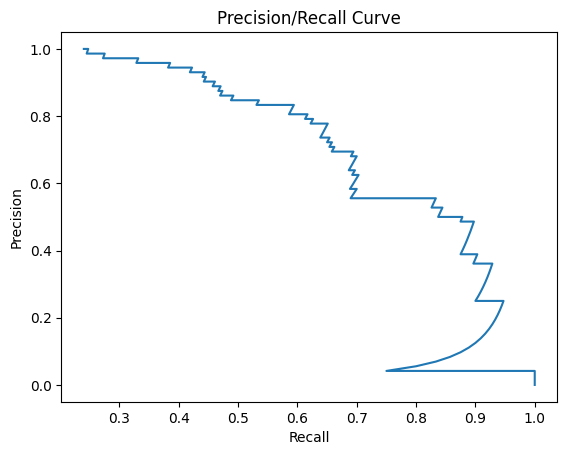

In [23]:


plt.figure(1) # 创建图表1
plt.title('Precision/Recall Curve')# give plot a title
plt.xlabel('Recall')# make axis labels
plt.ylabel('Precision')
 
# #y_true和y_scores分别是gt label和predict score
# y_true = np.array([0, 0, 1, 1])
# y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(df_pred['murong评测-FA'], df_pred['pred_prob'])
plt.figure(1)
plt.plot(precision, recall)


In [45]:
best_threshold = 0.9
TP = sum([True if (label==1 and pred_prob>=best_threshold) else False for label, pred_prob in zip(df_pred['murong评测-FA'].astype('int'), df_pred['pred_prob'].astype(float))])
pred_positive = sum(df_pred['pred_prob'].astype(float)>=best_threshold)
true_positive = sum(df_pred['murong评测-FA'].astype('int'))
accuracyScore = accuracy_score(df_pred['murong评测-FA'].astype('int'), df_pred['pred_prob'].astype(float)>=best_threshold)
f1_score(df_pred['murong评测-FA'].astype('int'), df_pred['match_score'].astype(float)>=best_threshold)
print(f"current threshold is: {best_threshold}")
print(f"assemblyModel precision_score is: {TP}/{pred_positive}={TP/pred_positive}")
print(f"assemblyModel recall_score is: {TP}/{true_positive}={TP/true_positive}")
print(f"assemblyModel accuracy_score is: {accuracyScore}")

current threshold is: 0.9
assemblyModel precision_score is: 35/39=0.8974358974358975
assemblyModel recall_score is: 35/72=0.4861111111111111
assemblyModel accuracy_score is: 0.8633333333333333


In [46]:
f1_score(df_pred['murong评测-FA'].astype('int'), df_pred['match_score'].astype(float)>=best_threshold)

0.7169811320754716

In [47]:
best_threshold = 0.8
TP = sum([True if (label==1 and pred_prob>=best_threshold) else False for label, pred_prob in zip(df_pred['murong评测-FA'].astype('int'), df_pred['pred_prob'].astype(float))])
pred_positive = sum(df_pred['pred_prob'].astype(float)>=best_threshold)
true_positive = sum(df_pred['murong评测-FA'].astype('int'))
accuracyScore = accuracy_score(df_pred['murong评测-FA'].astype('int'), df_pred['pred_prob'].astype(float)>=best_threshold)
print(f"current threshold is: {best_threshold}")
print(f"assemblyModel precision_score is: {TP}/{pred_positive}={TP/pred_positive}")
print(f"assemblyModel recall_score is: {TP}/{true_positive}={TP/true_positive}")
print(f"assemblyModel accuracy_score is: {accuracyScore}")

current threshold is: 0.8
assemblyModel precision_score is: 40/50=0.8
assemblyModel recall_score is: 40/72=0.5555555555555556
assemblyModel accuracy_score is: 0.86


In [25]:
df_pred['murong评测-FA'].value_counts()


murong评测-FA
0    228
1     72
Name: count, dtype: int64

In [22]:
best_threshold = 0.85
TP = sum([True if (label==1 and pred_prob>=best_threshold) else False for label, pred_prob in zip(df_pred['murong评测-FA'].astype('int'), df_pred['pred_prob'].astype(float))])
pred_positive = sum(df_pred['pred_prob'].astype(float)>=best_threshold)
true_positive = sum(df_pred['murong评测-FA'].astype('int'))
accuracyScore = accuracy_score(df_pred['murong评测-FA'].astype('int'), df_pred['pred_prob'].astype(float)>=best_threshold)
print(f"current threshold is: {best_threshold}")
print(f"assemblyModel precision_score is: {TP}/{pred_positive}={TP/pred_positive}")
print(f"assemblyModel recall_score is: {TP}/{true_positive}={TP/true_positive}")
print(f"assemblyModel accuracy_score is: {accuracyScore}")

current threshold is: 0.85
assemblyModel precision_score is: 38/46=0.8260869565217391
assemblyModel recall_score is: 38/72=0.5277777777777778
assemblyModel accuracy_score is: 0.86


In [27]:
best_threshold = 0.8
TP = sum([True if (label==1 and pred_prob>=best_threshold) else False for label, pred_prob in zip(df_pred['murong评测-FA'].astype('int'), df_pred['pred_prob'].astype(float))])
pred_positive = sum(df_pred['pred_prob'].astype(float)>=best_threshold)
true_positive = sum(df_pred['murong评测-FA'].astype('int'))
accuracyScore = accuracy_score(df_pred['murong评测-FA'].astype('int'), df_pred['pred_prob'].astype(float)>=best_threshold)
print(f"current threshold is: {best_threshold}")
print(f"assemblyModel precision_score is: {TP}/{pred_positive}={TP/pred_positive}")
print(f"assemblyModel recall_score is: {TP}/{true_positive}={TP/true_positive}")
print(f"assemblyModel accuracy_score is: {accuracyScore}")

current threshold is: 0.8
assemblyModel precision_score is: 40/50=0.8
assemblyModel recall_score is: 40/72=0.5555555555555556
assemblyModel accuracy_score is: 0.86


In [37]:
best_threshold = 0.8
TP = sum([True if (label==1 and pred_prob>=best_threshold) else False for label, pred_prob in zip(df_pred['murong评测-FA'].astype('int'), df_pred['match_score'].astype(float))])
pred_positive = sum(df_pred['match_score'].astype(float)>=best_threshold)
true_positive = sum(df_pred['murong评测-FA'].astype('int'))
best_accuracy = accuracy_score(df_pred['murong评测-FA'].astype('int'), df_pred['match_score'].astype(float)>=best_threshold)
f1_score(df_pred['murong评测-FA'].astype('int'), df_pred['match_score'].astype(float)>=best_threshold)
print(f"best threshold is: {best_threshold}")
print(f"rule best precision_score is: {TP}/{pred_positive}={TP/pred_positive}")
print(f"rule best recall_score is: {TP}/{true_positive}={TP/true_positive}")
print(f"rule best accuracy_score is: {best_accuracy}")

best threshold is: 0.8
rule best precision_score is: 58/88=0.6590909090909091
rule best recall_score is: 58/72=0.8055555555555556
rule best accuracy_score is: 0.8533333333333334


In [38]:
f1_score(df_pred['murong评测-FA'].astype('int'), df_pred['match_score'].astype(float)>=best_threshold)


0.7250000000000001

In [49]:
from collections import OrderedDict
l = [1,2,1,3,4]
list(OrderedDict.fromkeys(l))

[1, 2, 3, 4]

In [62]:
import openai
import os
system_role = """\
#Role
E-commerce Operations Specialist
#Goals
Extract key product information based on provided product titles and various product details
#Language
--English
#Workflows
--product_description: Concise and highlighting product features, with a word limit of 50 words
--brief_title: Summarize a brief and personalized product title within 10 words
--seo_title: With a word limit of 30 words
--google_category: Infer the Google product category
--shopify_category: Infer the Shopify product category
--type: Infer the product type
--tags: Infer product tags (up to 5) in descending order of priority, separated by commas
--gender: Determine the gender of the target audience (choose from male, female, unisex)
--age_group: Determine the age group of the target audience (choose from child, adult)
--adword_groups: Infer up to 3 adword groups
--adword_labels: Infer up to 5 adword labels
--material
--craftsmanship
--fashion_element
--style
--size
#Constraints
--The extracted information must not contain keywords related to cross-border, dropshipping, wholesale, made in China or the year 2022
--Google and Shopify product categories should be complete, hierarchical categories
--If an attribute value is not found, use an empty string ('')
--If an attribute has multiple values seperated by commas
#Output
--Output a JSON result only; no intermediate information is required
"""
title = "欧美跨境新款首饰爱心镶钻锆石项链简约个性时尚百搭耳饰厂家批发"
description = """材质:铜
处理工艺:镶钻
造型:心形
产地:汕尾
链子样式:十字链
颜色:天蓝色
流行元素:爱心/心形
上市年份/季节:2023年春季
风格:ins风
风格分类:个性风潮
产品类别:项饰
流行元素分类:形状/图案 """
user_content = f"title: {title}\ndescription: {description}\nplease output the JSON only"
openai.api_key = os.getenv("OPENAI_API_KEY")


In [65]:
completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": f"{system_role}"},
        {"role": "user", "content": f"{user_content}"}
    ]
)
completion.choices[0].message
usage_tokens = completion.usage.total_tokens

<>:9: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:9: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
/var/folders/bv/1ly9grbd6w143ngs2zd7406h0000gq/T/ipykernel_54150/3228408150.py:9: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  usage_tokens = ['usage']['total_tokens']
/var/folders/bv/1ly9grbd6w143ngs2zd7406h0000gq/T/ipykernel_54150/3228408150.py:9: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  usage_tokens = ['usage']['total_tokens']
/var/folders/bv/1ly9grbd6w143ngs2zd7406h0000gq/T/ipykernel_54150/3228408150.py:9: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  usage_tokens = ['usage']['total_tokens']


TypeError: list indices must be integers or slices, not str

In [66]:
completion

<OpenAIObject chat.completion id=chatcmpl-80BYe2yy6N9LbbtjQmsnMK1x9QjIB at 0x7fbd08a5d940> JSON: {
  "id": "chatcmpl-80BYe2yy6N9LbbtjQmsnMK1x9QjIB",
  "object": "chat.completion",
  "created": 1695055120,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "{\n  \"product_description\": \"This European and American cross-border jewelry necklace is simple, stylish, and versatile. It features a heart-shaped design with sparkling zircon stones. Made of copper using diamond inlay craftsmanship, this necklace is perfect for any occasion. Wholesale from the manufacturer.\",\n  \"brief_title\": \"Heart-shaped Zircon Necklace\",\n  \"seo_title\": \"European and American Heart-shaped Zircon Necklace\",\n  \"google_category\": \"Jewelry & Watches > Necklaces\",\n  \"shopify_category\": \"Jewelry > Necklaces\",\n  \"type\": \"\",\n  \"tags\": \"wholesale, necklace, heart-shaped, zircon, jewelry\",\n  \"gender\"

In [70]:
completion.choices[0]

<OpenAIObject at 0x7fbcd8cf43b0> JSON: {
  "index": 0,
  "message": {
    "role": "assistant",
    "content": "{\n  \"product_description\": \"This European and American cross-border jewelry necklace is simple, stylish, and versatile. It features a heart-shaped design with sparkling zircon stones. Made of copper using diamond inlay craftsmanship, this necklace is perfect for any occasion. Wholesale from the manufacturer.\",\n  \"brief_title\": \"Heart-shaped Zircon Necklace\",\n  \"seo_title\": \"European and American Heart-shaped Zircon Necklace\",\n  \"google_category\": \"Jewelry & Watches > Necklaces\",\n  \"shopify_category\": \"Jewelry > Necklaces\",\n  \"type\": \"\",\n  \"tags\": \"wholesale, necklace, heart-shaped, zircon, jewelry\",\n  \"gender\": \"unisex\",\n  \"age_group\": \"adult\",\n  \"adword_groups\": \"jewelry, necklaces, accessories\",\n  \"adword_labels\": \"wholesale, fashionable, trendy, heart-shaped, zircon\",\n  \"material\": \"Copper\",\n  \"craftsmanship\": \

In [75]:
import json
x = json.loads(completion.choices[0].message.content)

In [76]:
x.keys()

dict_keys(['product_description', 'brief_title', 'seo_title', 'google_category', 'shopify_category', 'type', 'tags', 'gender', 'age_group', 'adword_groups', 'adword_labels', 'material', 'craftsmanship', 'fashion_element', 'style', 'size', 'color'])

In [77]:
x

{'product_description': 'This European and American cross-border jewelry necklace is simple, stylish, and versatile. It features a heart-shaped design with sparkling zircon stones. Made of copper using diamond inlay craftsmanship, this necklace is perfect for any occasion. Wholesale from the manufacturer.',
 'brief_title': 'Heart-shaped Zircon Necklace',
 'seo_title': 'European and American Heart-shaped Zircon Necklace',
 'google_category': 'Jewelry & Watches > Necklaces',
 'shopify_category': 'Jewelry > Necklaces',
 'type': '',
 'tags': 'wholesale, necklace, heart-shaped, zircon, jewelry',
 'gender': 'unisex',
 'age_group': 'adult',
 'adword_groups': 'jewelry, necklaces, accessories',
 'adword_labels': 'wholesale, fashionable, trendy, heart-shaped, zircon',
 'material': 'Copper',
 'craftsmanship': 'Diamond Inlay',
 'fashion_element': 'Heart-shaped',
 'style': 'Ins Style',
 'size': '',
 'color': 'Sky Blue'}

In [97]:
import pandas as pd
names = ['category_id'] + [f'category_{i}' for i in range(1, 8, 1)]
df = pd.read_excel("/Users/fanke.chang/shop/product_coding/resources/taxonomy-with-ids.zh-CN.xls", names=names)

In [98]:
df

,category_id,category_1,category_2,category_3,category_4,category_5,category_6,category_7
0,500096,五金/硬件,五金泵,NaN,NaN,NaN,NaN,NaN
1,500100,五金/硬件,五金泵,井泵/系统,NaN,NaN,NaN,NaN
2,500101,五金/硬件,五金泵,实用泵,NaN,NaN,NaN,NaN
3,500099,五金/硬件,五金泵,家用电器泵,NaN,NaN,NaN,NaN
4,500098,五金/硬件,五金泵,泳池、喷泉与池塘泵,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5589,543532,饮食/烟酒,饮料/饮品,饮用水/纯净水,泉水,NaN,NaN,NaN
5590,543531,饮食/烟酒,饮料/饮品,饮用水/纯净水,碳酸水,NaN,NaN,NaN
5591,543535,饮食/烟酒,饮料/饮品,饮用水/纯净水,碳酸水,无味碳酸水,NaN,NaN
5592,543534,饮食/烟酒,饮料/饮品,饮用水/纯净水,碳酸水,调味碳酸水,NaN,NaN


In [89]:
df.columns

Index(['632', '五金/硬件', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')

In [94]:
df = pd.read_excel("/Users/fanke.chang/shop/product_coding/resources/taxonomy-with-ids.en-US.xls")
df

,1,Animals & Pet Supplies,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,3237,Animals & Pet Supplies,Live Animals,NaN,NaN,NaN,NaN,NaN
1,2,Animals & Pet Supplies,Pet Supplies,NaN,NaN,NaN,NaN,NaN
2,3,Animals & Pet Supplies,Pet Supplies,Bird Supplies,NaN,NaN,NaN,NaN
3,7385,Animals & Pet Supplies,Pet Supplies,Bird Supplies,Bird Cage Accessories,NaN,NaN,NaN
4,499954,Animals & Pet Supplies,Pet Supplies,Bird Supplies,Bird Cage Accessories,Bird Cage Bird Baths,NaN,NaN
...,...,...,...,...,...,...,...,...
5589,3540,Vehicles & Parts,Vehicles,Watercraft,NaN,NaN,NaN,NaN
5590,3095,Vehicles & Parts,Vehicles,Watercraft,Motor Boats,NaN,NaN,NaN
5591,1130,Vehicles & Parts,Vehicles,Watercraft,Personal Watercraft,NaN,NaN,NaN
5592,3087,Vehicles & Parts,Vehicles,Watercraft,Sailboats,NaN,NaN,NaN


In [95]:
len(df.columns)

8

In [8]:
import pandas as pd
df = pd.read_parquet("/Users/fanke.chang/Downloads/part-00000-7a3ea447-08d1-4ef6-a177-c70b8fcf9f66-c000.zstd.parquet")
df

,index_id,pp_id,formatted_address,raw_address,address_component,tag
0,1cPH_RiskV77xODUldkER6b,0cPH_Risk1763437198982337588,"Sitio Bana, Dolores, Mabalacat, Pampanga, 2010...",sitio bana,"{""index_id"": ""0cPH_Risk1763437198982337588"", ""...",cluster
1,46PH_Riskl981xgUkg2lWEg,13PH_Risk1779403192334809089,"Block 0 Lot 11, Phase C Woodlane, Malagasang I...","Woodlane Phase C,B10 L11","{""index_id"": ""13PH_Risk1779403192334809089"", ""...",cluster
2,36PH_RiskrVjQOPc2vaQYo8,19PH_Risk1742850294846897153,"Block 63 Lot 3b, Santo Cristo (Barangay 3), Da...",blk 63 lot 3b brgy sto cristo ( INFRONT OF DJ ...,"{""index_id"": ""19PH_Risk1742850294846897153"", ""...",cluster
3,5ePH_RiskjKdPelUxY7jo3G,1cPH_Risk1688328069049531393,"171 Road Avenue, Zone Z 23, East Rembo, Makati...",171 Z 23rd avenue,"{""index_id"": ""1cPH_Risk1688328069049531393"", ""...",cluster
4,1cPH_RiskV77xODUldkER6b,27PH_Risk1681998769127868416,"Sitio Bana, Dolores, Mabalacat, Pampanga, 2010...",Sitio bana dolores mabalacat,"{""index_id"": ""27PH_Risk1681998769127868416"", ""...",cluster
...,...,...,...,...,...,...
2111,76PH_RiskdQroe9i2g2D00a,0bPH_Risk1748736815798012929,"Rodriguez Store, 45, Purok 3, Villaros, Bagaba...","Rodriguez Store,45,Prk 3,Villaros","{""index_id"": ""0bPH_Risk1748736815798012929"", ""...",independent
2112,44PH_RiskAqbpB2tr87KmP3,50PH_Risk1806295342767432754,"Room For, 29 Ilang Ilang Street, Payatas, Quez...","29 Ilang Ilang St,Payatas A Quezon City( GILID...","{""index_id"": ""50PH_Risk1806295342767432754"", ""...",independent
2113,54PH_RiskbG1BWdFW93bLqr,82PH_Risk1792114578316053536,"Del Rosario, Naga City, Camarines Sur, 4400 So...","Naga City District Jail Male Dormitory,Del Ros...","{""index_id"": ""82PH_Risk1792114578316053536"", ""...",independent
2114,5bPH_Risk3A27kZuvYkBo73,80PH_Risk1802611283918715945,"Celine Homes, Block 58 Lot 4, Estefania, Bacol...","Blk 58,Lot 4,Celine Homes,B.C.","{""index_id"": ""80PH_Risk1802611283918715945"", ""...",independent


In [9]:
df.sort_values(['index_id','formatted_address']).to_csv('~/Downloads/cluster_sample_test', sep='\t', index=False)